In [53]:
from pathlib import Path
import numpy as np
import pandas as pd
import tarfile
import urllib.request

from matplotlib import pyplot as plt, rcParams
from tensorflow.python.framework.test_ops import FuncAttr

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
datasets_path = Path('../datasets')


def load_housing_data():
    tarball_path = datasets_path / "housing.tgz"
    if not tarball_path.is_file():
        Path("../datasets").mkdir(exist_ok=True, parents=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall("datasets")
    return pd.read_csv(datasets_path / "housing/housing.csv")

In [3]:
housing = load_housing_data()
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [4]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [7]:
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

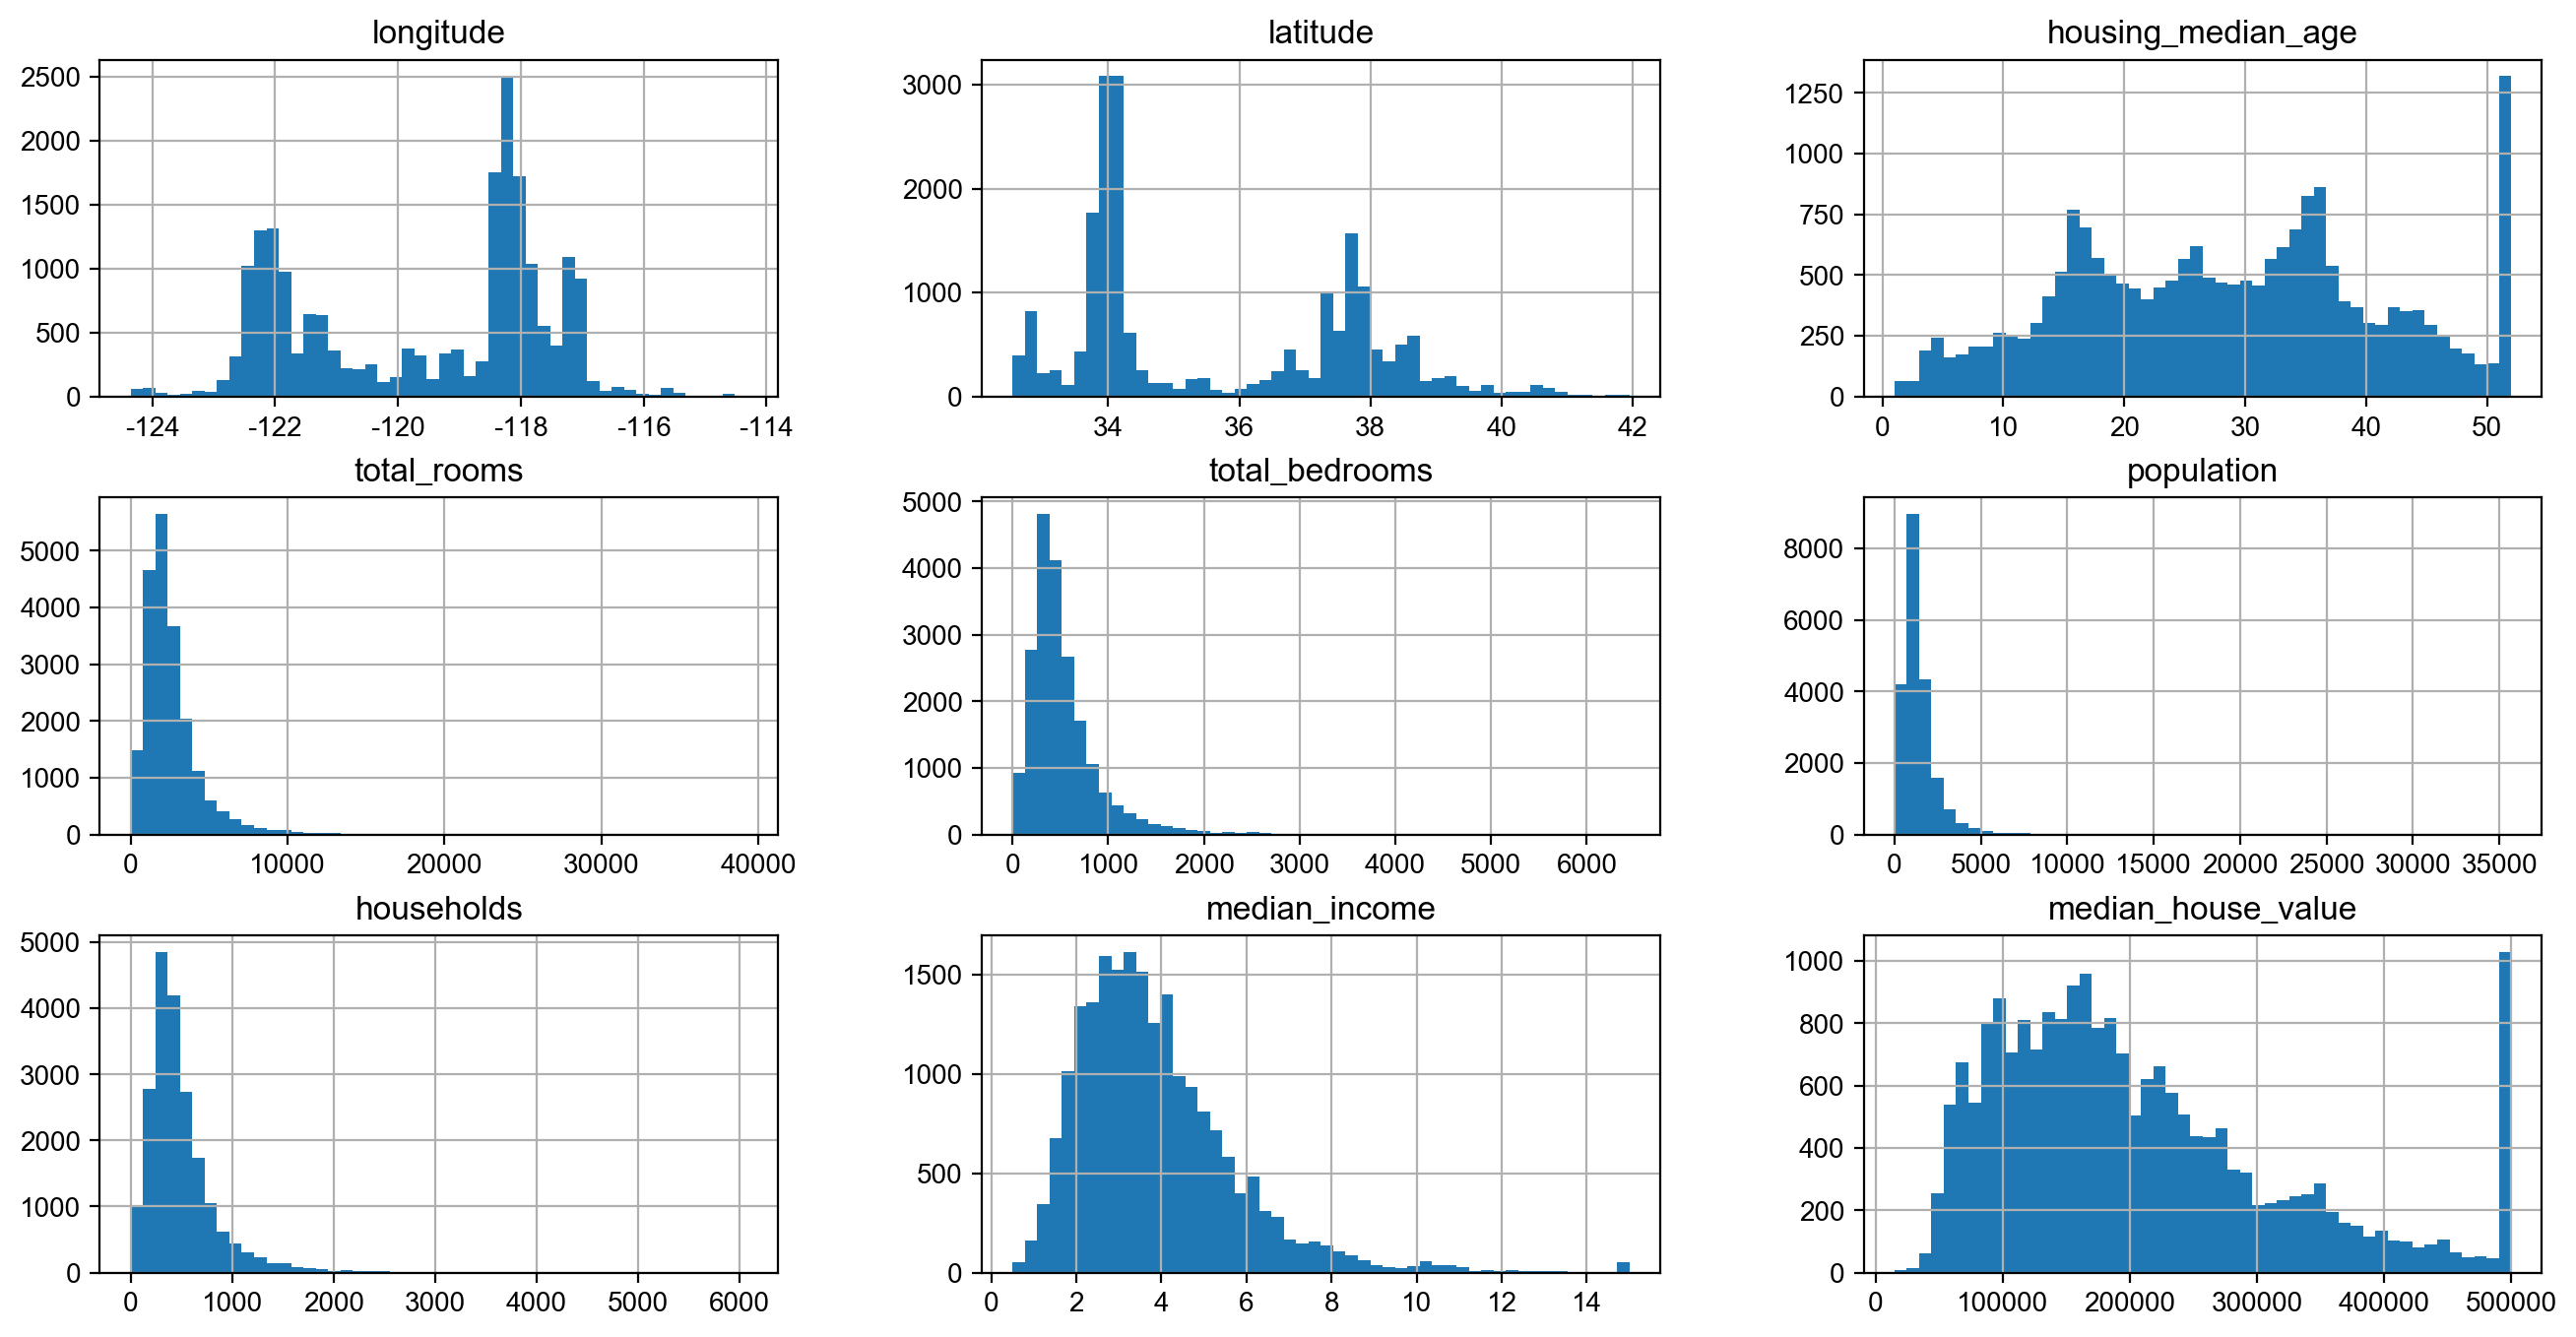

In [29]:
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(16, 8))
plt.show()

In [30]:
# 创建测试集(每次运行生成的测试集都不一样)
def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]


train_set, test_set = shuffle_and_split_data(housing, 0.2)
print(len(train_set), len(test_set))

16512 4128


> 生成同一数据集的10个不同的分层拆分

In [31]:
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
stratified_splits = []

housing['income_cat'] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
# 第一个参数 housing：这是你想要从中抽取样本的完整数据集（通常是特征数据）。
# 第二个参数 housing['income_cat']：这是进行分层的依据。它告诉 splitter 在划分训练集和测试集时，要尽量保持 income_cat 这一列中各个类别的比例与原始数据集中一致。例如，如果你的原始数据中有20%的房产属于收入类别 '1'，那么 splitter 会努力确保在它生成的每一个训练集和测试集中，也有大约20%的房产属于收入类别 '1'。
for train_index, test_index in splitter.split(housing, housing['income_cat']):
    stratified_train_set_n = housing.iloc[train_index]
    stratified_test_set_n = housing.iloc[test_index]
    stratified_splits.append([stratified_train_set_n, stratified_test_set_n])

In [32]:
# 使用第一个分层拆分
stratified_train_set, stratified_test_set = stratified_splits[0]
print(len(stratified_train_set), len(stratified_test_set))

16512 4128


In [33]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)


# 随机切分训练集和测试集
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(housing),
    "Stratified %": income_cat_proportions(stratified_train_set),
    "Random %": income_cat_proportions(test_set)
}).sort_index()

compare_props.index.name = "Income Category"
compare_props["Strat. Error %"] = (compare_props["Stratified %"] / compare_props["Overall %"] - 1)
compare_props["Random. Error %"] = (compare_props["Random %"] / compare_props["Overall %"] - 1)
(compare_props * 100).round(2)
# 使用分层抽样生成的测试集和原始数据集的收入类别几乎相同，而使用随机采样生成的测试集，收入类别比例存在偏差

Overall %  Stratified %  Random %  Strat. Error %  \
Income Category                                                      
1                     3.98          3.98      4.24           -0.09   
2                    31.88         31.89     30.74            0.00   
3                    35.06         35.06     34.52            0.00   
4                    17.63         17.63     18.41           -0.01   
5                    11.44         11.45     12.09            0.02   

                 Random. Error %  
Income Category                   
1                           6.45  
2                          -3.59  
3                          -1.53  
4                           4.42  
5                           5.63

> 使用train_test_split中的stratify参数可以很方便获得拆分

In [34]:
from sklearn.model_selection import train_test_split

#根据 income_cat 列以分层的方式切分训练集和测试集
strat_train_set, strat_test_set = train_test_split(housing, 
                                                   test_size=0.2,
                                                   stratify=housing['income_cat'],
                                                   random_state=42)

In [35]:
# 删除income_cat
for set_ in (strat_train_set, strat_test_set):
    set_.drop(['income_cat'], axis=1, inplace=True)

In [36]:
strat_train_set.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
13096    -122.42     37.80                52.0       3321.0          1115.0   
14973    -118.38     34.14                40.0       1965.0           354.0   
3785     -121.98     38.36                33.0       1083.0           217.0   
14689    -117.11     33.75                17.0       4174.0           851.0   
20507    -118.15     33.77                36.0       4366.0          1211.0   

       population  households  median_income  median_house_value  \
13096      1576.0      1034.0         2.0987            458300.0   
14973       666.0       357.0         6.0876            483800.0   
3785        562.0       203.0         2.4330            101700.0   
14689      1845.0       780.0         2.2618             96100.0   
20507      1912.0      1172.0         3.5292            361800.0   

      ocean_proximity  
13096        NEAR BAY  
14973       <1H OCEAN  
3785           INLAND  
14689          INLAND  
20507      NEAR OCEAN

In [37]:
strat_test_set.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
3905     -121.95     37.11                21.0       2387.0           357.0   
16821    -118.01     33.89                36.0       1589.0           265.0   
2900     -118.18     33.74                30.0       5915.0          1750.0   
7193     -122.48     37.74                52.0       2166.0           423.0   
13928    -122.39     37.78                 5.0       1405.0           515.0   

       population  households  median_income  median_house_value  \
3905        913.0       341.0         7.7360            397700.0   
16821       804.0       272.0         4.6354            202900.0   
2900       2136.0      1503.0         4.0968            310000.0   
7193       1072.0       370.0         4.1310            314300.0   
13928       725.0       392.0         3.6037            187500.0   

      ocean_proximity  
3905        <1H OCEAN  
16821       <1H OCEAN  
2900       NEAR OCEAN  
7193       NEAR OCEAN  
13928        NEAR BAY

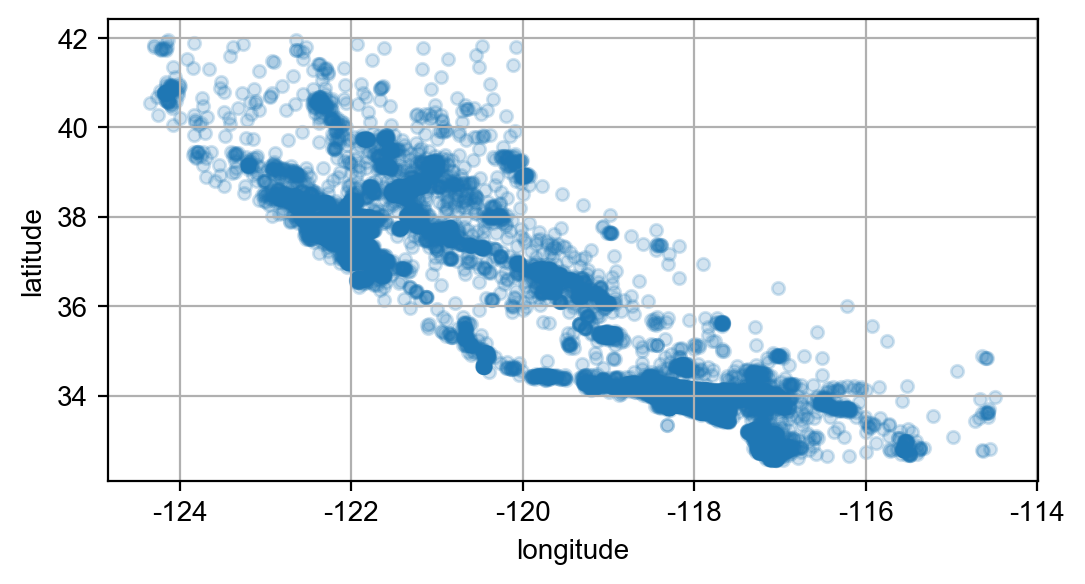

In [60]:
housing_copy = strat_train_set.copy()
housing_copy.drop(['ocean_proximity'], axis=1, inplace=True)
housing_copy.plot(kind='scatter', 
                  x='longitude',
                  y='latitude', 
                  grid=True, 
                  alpha=0.2,
                  figsize=(6, 3));

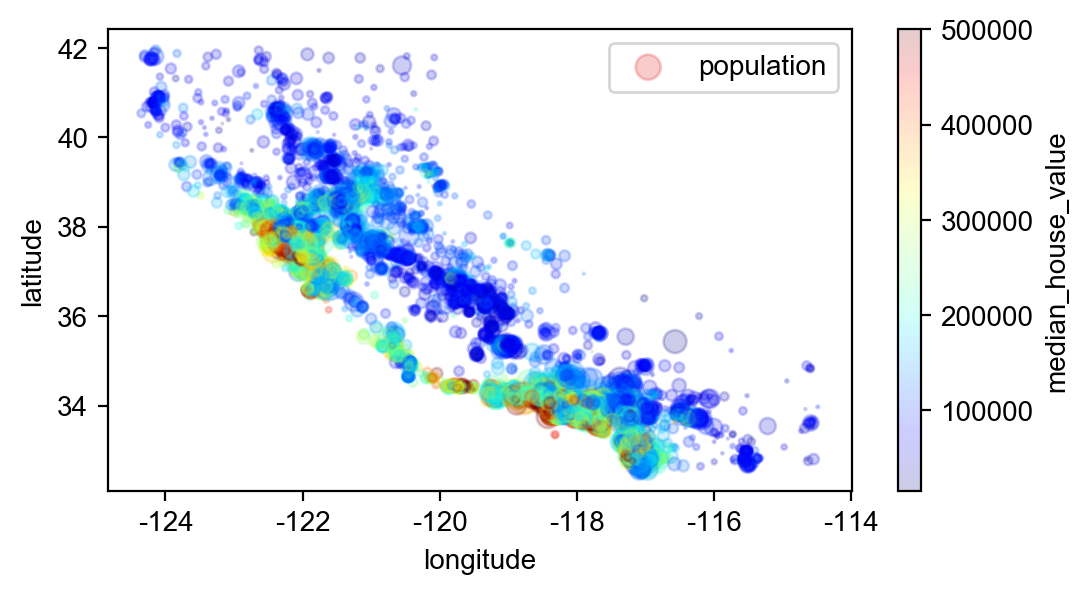

In [55]:
housing_copy.plot(kind="scatter",
                  x="longitude",
                  y="latitude",
                  alpha=0.2,
                  c="median_house_value",
                  s=housing_copy["population"] / 100,
                  label="population",
                  cmap="jet",
                  colorbar=True,
                  sharex=False,
                  legend=True,
                  figsize=(6, 3));

### 寻找相关性

In [58]:
corr_matrix = housing_copy.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

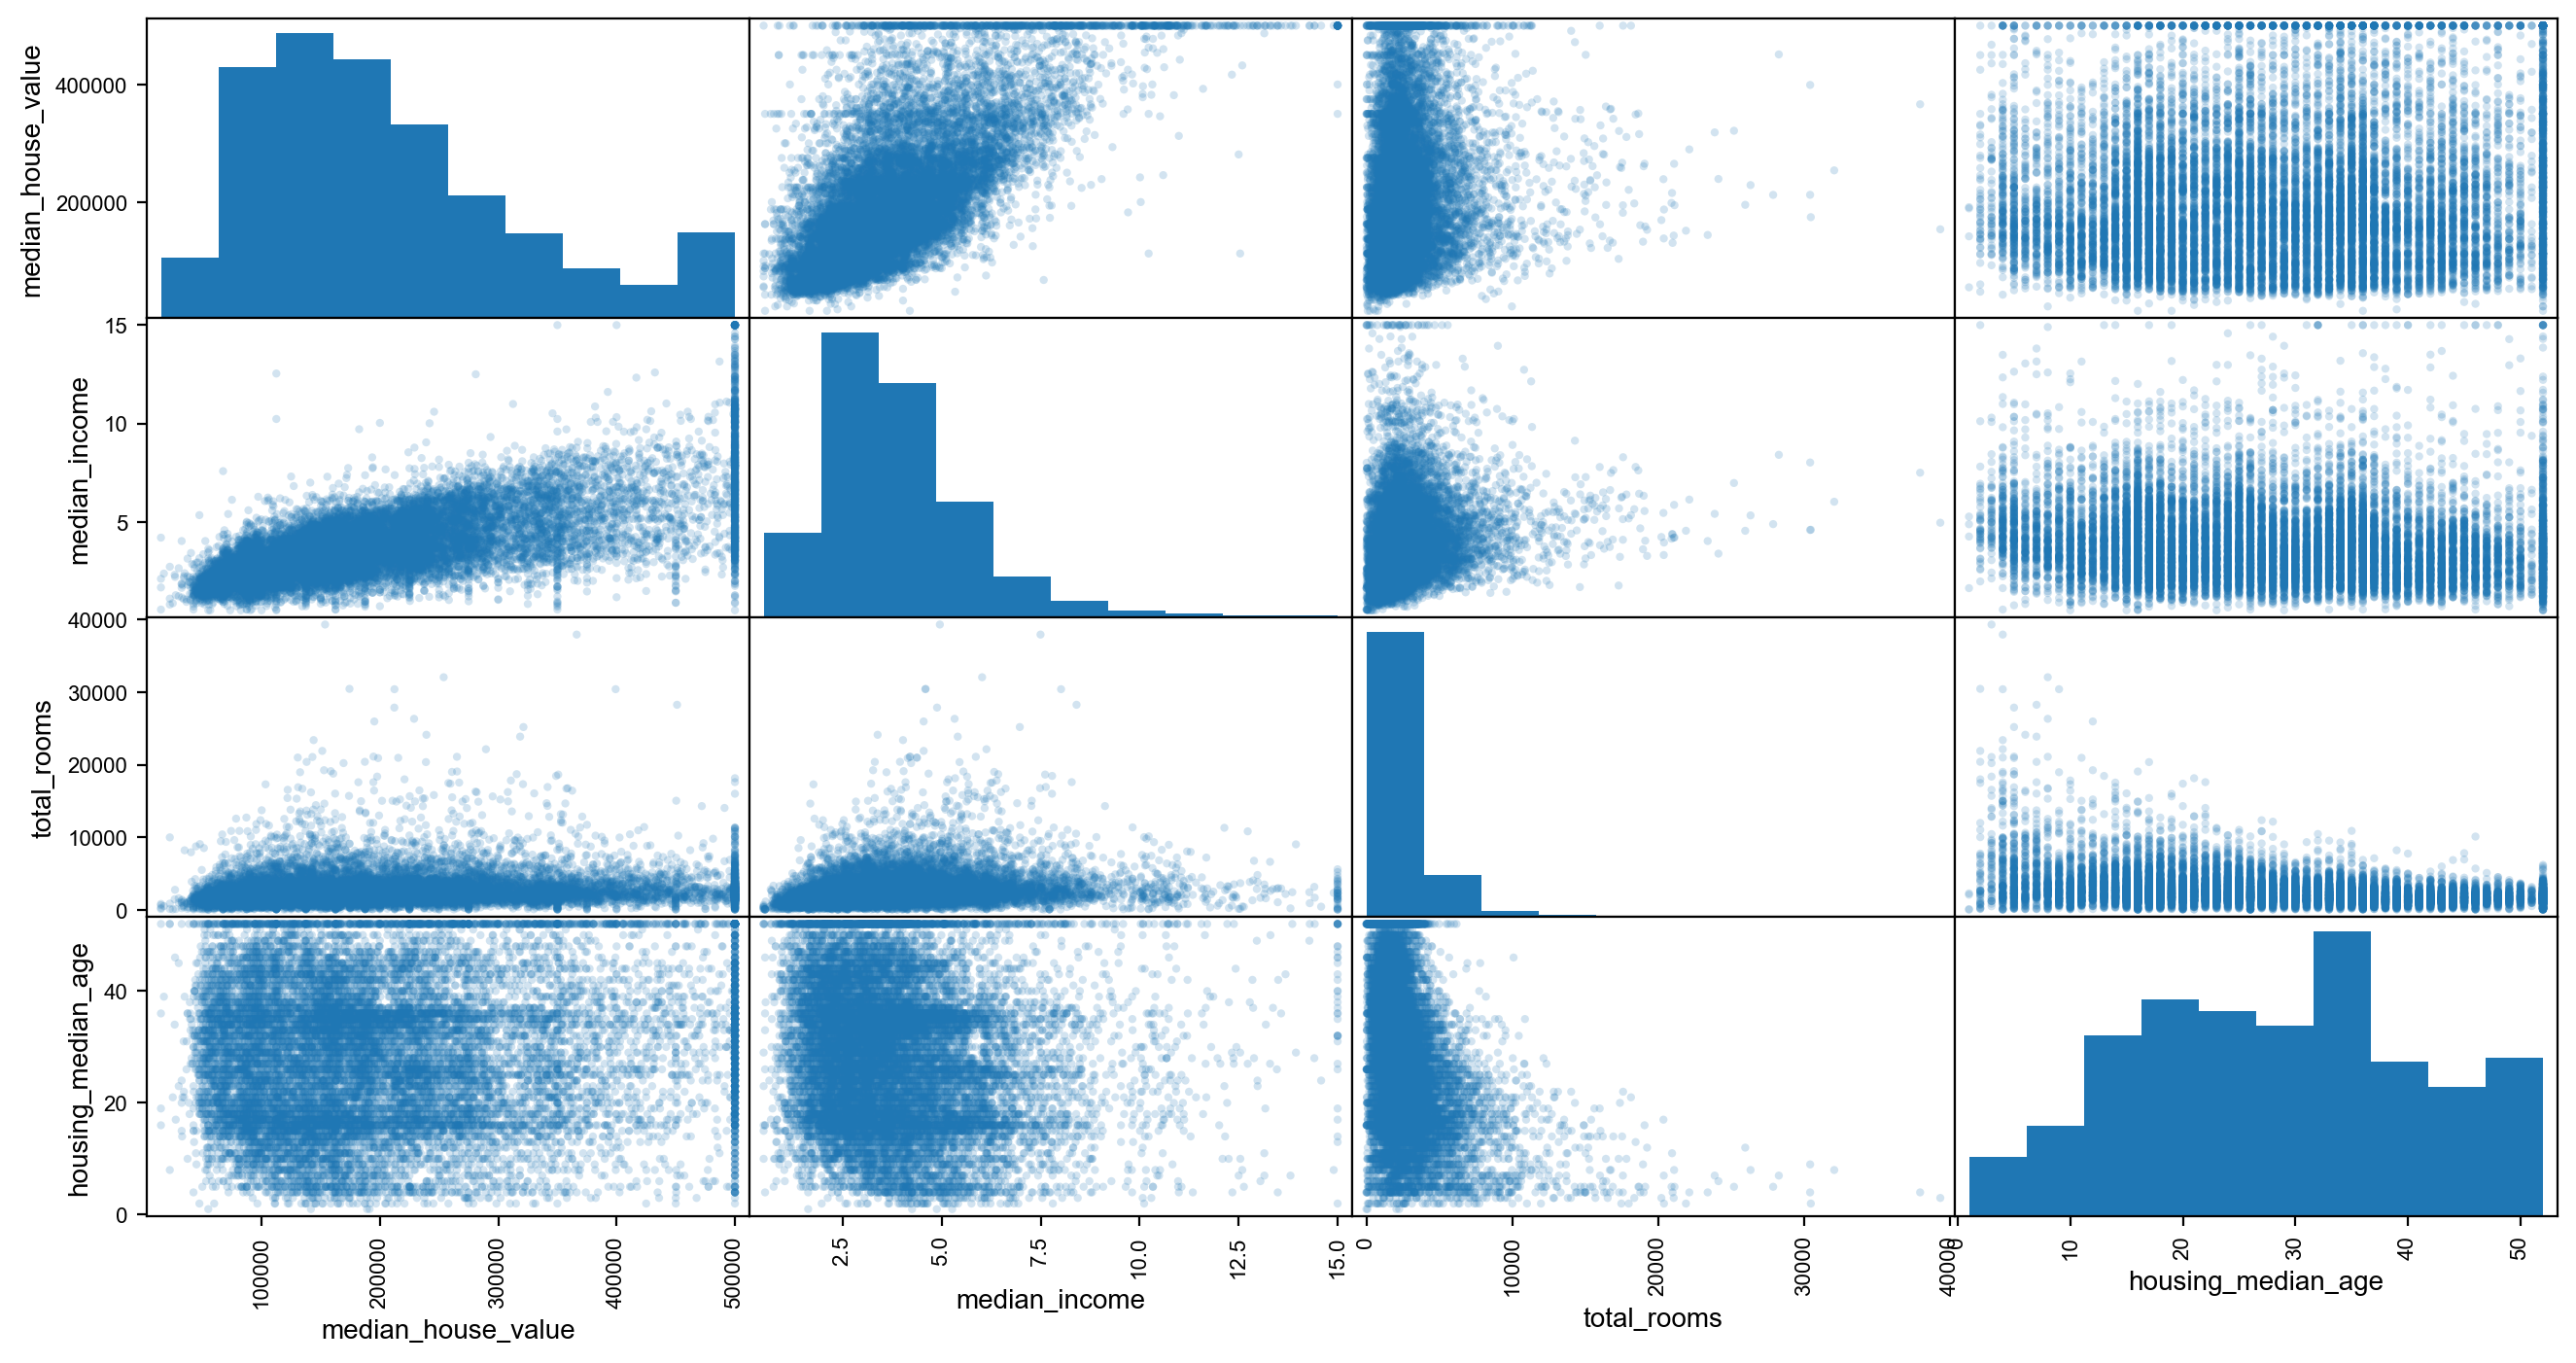

In [56]:
# 查看属性之间相关性的另一种方法是使用Pandas的scatter_matrix()函数，该函数将每个数值属性与其他每个数值属性进行对比。
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income",
              "total_rooms", "housing_median_age"]
scatter_matrix(housing_copy[attributes], alpha=0.2, figsize=(16, 8))
plt.show()

<Axes: xlabel='median_income', ylabel='median_house_value'>

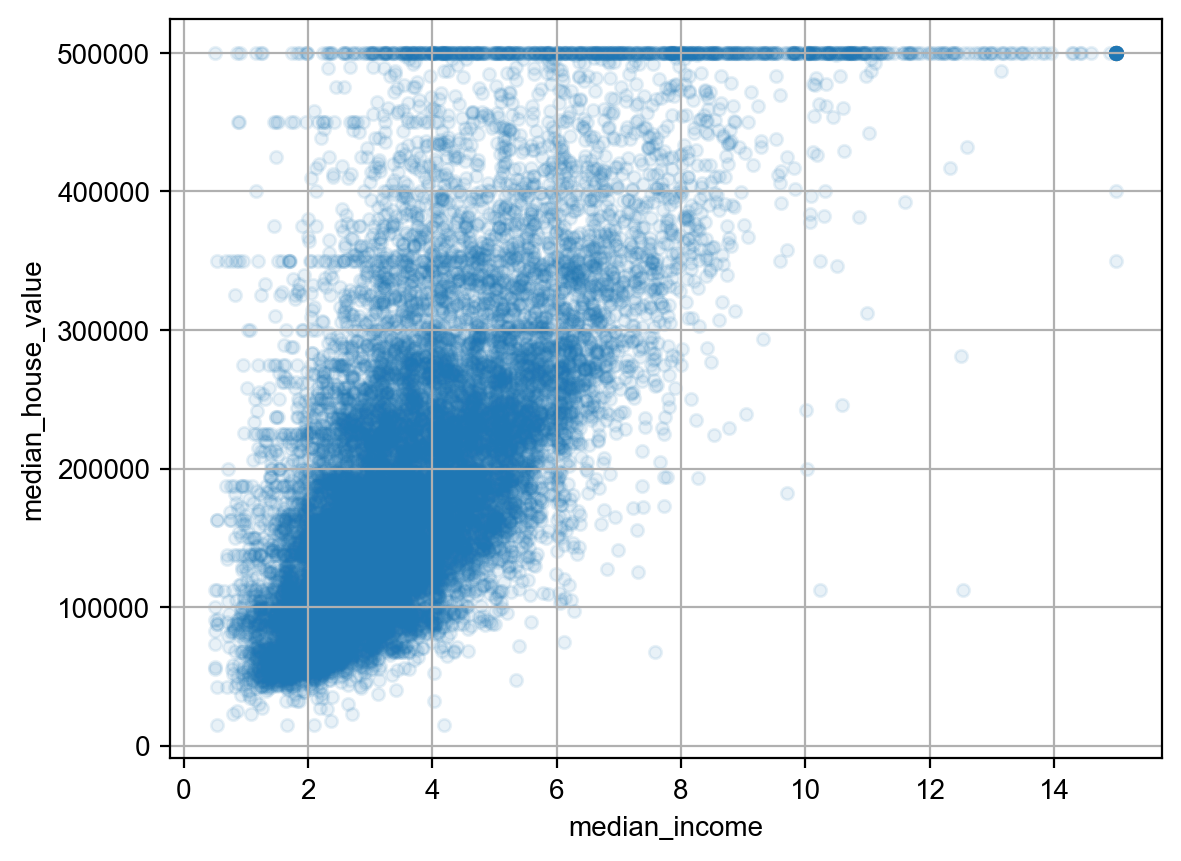

In [21]:
housing_copy.plot(kind='scatter', x="median_income",
                  y="median_house_value", grid=True, alpha=0.1)

> 在为机器学习算法准备数据之前，你可能想要做的最后一件事是尝试各种属性组合。探索属性之间有趣的相关性，尤其是与目标属性之间的相关性。

In [22]:
housing_copy["rooms_per_house"] = housing_copy["total_rooms"] / \
    housing_copy["households"]
housing_copy["bedrooms_ratio"] = housing_copy["total_bedrooms"] / \
    housing_copy["total_rooms"]
housing_copy["people_per_house"] = housing_copy["population"] / \
    housing_copy["households"]
housing_copy.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
13096    -122.42     37.80                52.0       3321.0          1115.0   
14973    -118.38     34.14                40.0       1965.0           354.0   
3785     -121.98     38.36                33.0       1083.0           217.0   
14689    -117.11     33.75                17.0       4174.0           851.0   
20507    -118.15     33.77                36.0       4366.0          1211.0   

       population  households  median_income  median_house_value  \
13096      1576.0      1034.0         2.0987            458300.0   
14973       666.0       357.0         6.0876            483800.0   
3785        562.0       203.0         2.4330            101700.0   
14689      1845.0       780.0         2.2618             96100.0   
20507      1912.0      1172.0         3.5292            361800.0   

       rooms_per_house  bedrooms_ratio  people_per_house  
13096         3.211799        0.335742          1.524178  
14973         5.504202        0.180153          1.865546  
3785          5.334975        0.200369          2.768473  
14689         5.351282        0.203881          2.365385  
20507         3.725256        0.277371          1.631399

In [31]:
#pd.set_option('display.max_rows', 20)
corr_matrix_1 = housing_copy.corr()
corr_matrix_1["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

### 2.5 为机器学习准备数据

In [24]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_label = strat_train_set["median_house_value"].copy()

In [25]:
print(len(strat_train_set), len(housing))

16512 16512


In [26]:
housing.head(5)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
13096    -122.42     37.80                52.0       3321.0          1115.0   
14973    -118.38     34.14                40.0       1965.0           354.0   
3785     -121.98     38.36                33.0       1083.0           217.0   
14689    -117.11     33.75                17.0       4174.0           851.0   
20507    -118.15     33.77                36.0       4366.0          1211.0   

       population  households  median_income ocean_proximity  
13096      1576.0      1034.0         2.0987        NEAR BAY  
14973       666.0       357.0         6.0876       <1H OCEAN  
3785        562.0       203.0         2.4330          INLAND  
14689      1845.0       780.0         2.2618          INLAND  
20507      1912.0      1172.0         3.5292      NEAR OCEAN

-  使用sklearn.impute填缺失值

In [32]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

In [28]:
housing.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
ocean_proximity        object
dtype: object

-  填充缺失值只能针对数值类型，创建仅包含数值属性的数据副本（这将排除文本属性ocean_proximity）

In [29]:
housing_num = housing.select_dtypes(include=[np.number])
housing_num.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
13096    -122.42     37.80                52.0       3321.0          1115.0   
14973    -118.38     34.14                40.0       1965.0           354.0   
3785     -121.98     38.36                33.0       1083.0           217.0   
14689    -117.11     33.75                17.0       4174.0           851.0   
20507    -118.15     33.77                36.0       4366.0          1211.0   

       population  households  median_income  
13096      1576.0      1034.0         2.0987  
14973       666.0       357.0         6.0876  
3785        562.0       203.0         2.4330  
14689      1845.0       780.0         2.2618  
20507      1912.0      1172.0         3.5292

In [30]:
# 使用中位值填充缺失值
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [30]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [31]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [32]:
housing_num.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype='object')

In [33]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(
    X, columns=housing_num.columns, index=housing_num.index)
housing_tr.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
13096    -122.42     37.80                52.0       3321.0          1115.0   
14973    -118.38     34.14                40.0       1965.0           354.0   
3785     -121.98     38.36                33.0       1083.0           217.0   
14689    -117.11     33.75                17.0       4174.0           851.0   
20507    -118.15     33.77                36.0       4366.0          1211.0   

       population  households  median_income  
13096      1576.0      1034.0         2.0987  
14973       666.0       357.0         6.0876  
3785        562.0       203.0         2.4330  
14689      1845.0       780.0         2.2618  
20507      1912.0      1172.0         3.5292

#### 将ocean_proximity文本转换为数组

In [34]:
housing_data['ocean_proximity'].value_counts()
housing_cat = housing_data[["ocean_proximity"]]
housing_cat.head()

ocean_proximity
13096        NEAR BAY
14973       <1H OCEAN
3785           INLAND
14689          INLAND
20507      NEAR OCEAN

In [35]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:5]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.]])

In [36]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [37]:
# 使用独热编码
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder()
housing_cat_onehot = onehot_encoder.fit_transform(housing_cat)
housing_cat_onehot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [38]:
housing_cat_onehot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [39]:
onehot_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [40]:
df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
pd.get_dummies(df_test, dtype="int")

ocean_proximity_INLAND  ocean_proximity_NEAR BAY
0                       1                         0
1                       0                         1

#### get_dummies不能替代OneHotEncoder的原因是OneHotEncoder的优势在于它会记住经过了哪些类别的训练。

In [41]:
onehot_encoder.transform(df_test).toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [42]:
onehot_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [43]:
ordinal_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [44]:
ordinal_encoder.get_feature_names_out()

array(['ocean_proximity'], dtype=object)

In [45]:
df_test_unknown = pd.DataFrame({"ocean_proximity": ["<2H OCEAN", "ISLAND"]})
pd.get_dummies(df_test_unknown, dtype="int")

ocean_proximity_<2H OCEAN  ocean_proximity_ISLAND
0                          1                       0
1                          0                       1

#### OneHotEncoder更聪明：它会检测未知类别并引发异常。如果你愿意，可以将handle_unknown超参数设置为“忽略”，在这种情况下，它将只用零表示未知类别

In [46]:
ordinal_encoder.handle_unknown = "ignore"
df_output = pd.DataFrame(ordinal_encoder.transform(df_test_unknown),
                         columns=ordinal_encoder.get_feature_names_out(),
                         index=df_test_unknown.index)
df_output

ocean_proximity
0              0.0
1              2.0

### 特征缩放和转换

In [47]:
from sklearn.preprocessing import MinMaxScaler

# 首先它减去平均值（因此标准化值的均值为零），然后将结果除以标准差（因此标准化值的标准差等于1）
# 假设一个地区的收入中位数等于100（错误数据），而不是通常的0～15。最小—最大缩放到0～1范围会将此异常值映射到1，并将所有其他值压缩到0～0.15，受异常值影响较大。
normalizer_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = normalizer_scaler.fit_transform(housing_num)

In [48]:
housing_num_min_max_scaled = pd.DataFrame(housing_num_min_max_scaled,
                                          columns=housing_num.columns,
                                          index=housing_num.index)
housing_num_min_max_scaled.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
13096  -0.608519  0.117021            1.000000    -0.831171       -0.641166   
14973   0.210953 -0.661702            0.529412    -0.900148       -0.886294   
3785   -0.519270  0.236170            0.254902    -0.945012       -0.930424   
14689   0.468560 -0.744681           -0.372549    -0.787782       -0.726204   
20507   0.257606 -0.740426            0.372549    -0.778015       -0.610243   

       population  households  median_income  
13096   -0.807018   -0.614336      -0.779479  
14973   -0.918660   -0.867090      -0.229293  
3785    -0.931419   -0.924585      -0.733369  
14689   -0.774015   -0.709166      -0.756983  
20507   -0.765796   -0.562815      -0.582171

In [49]:
from sklearn.preprocessing import StandardScaler

# 标准化受异常值的影响要小得多
# z = (x - u) / s
std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

In [50]:
len(housing_num_std_scaled)

16512

In [51]:
housing_num_std_scaled[:5]

array([[-1.42303652,  1.0136059 ,  1.86111875,  0.31191221,  1.35909429,
         0.13746004,  1.39481249, -0.93649149],
       [ 0.59639445, -0.702103  ,  0.90762971, -0.30861991, -0.43635598,
        -0.69377062, -0.37348471,  1.17194198],
       [-1.2030985 ,  1.27611874,  0.35142777, -0.71224036, -0.75958421,
        -0.78876841, -0.77572662, -0.75978881],
       [ 1.23121557, -0.88492444, -0.91989094,  0.70226169,  0.73623112,
         0.38317548,  0.73137454, -0.85028088],
       [ 0.71136206, -0.87554898,  0.58980003,  0.79012465,  1.58558998,
         0.44437597,  1.75526303, -0.18036472]])

In [52]:
housing_num_std_scaled = pd.DataFrame(housing_num_std_scaled,
                                      columns=housing_num.columns,
                                      index=housing_num.index)
housing_num_std_scaled.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
13096  -1.423037  1.013606            1.861119     0.311912        1.359094   
14973   0.596394 -0.702103            0.907630    -0.308620       -0.436356   
3785   -1.203098  1.276119            0.351428    -0.712240       -0.759584   
14689   1.231216 -0.884924           -0.919891     0.702262        0.736231   
20507   0.711362 -0.875549            0.589800     0.790125        1.585590   

       population  households  median_income  
13096    0.137460    1.394812      -0.936491  
14973   -0.693771   -0.373485       1.171942  
3785    -0.788768   -0.775727      -0.759789  
14689    0.383175    0.731375      -0.850281  
20507    0.444376    1.755263      -0.180365

#### 使用对数转换

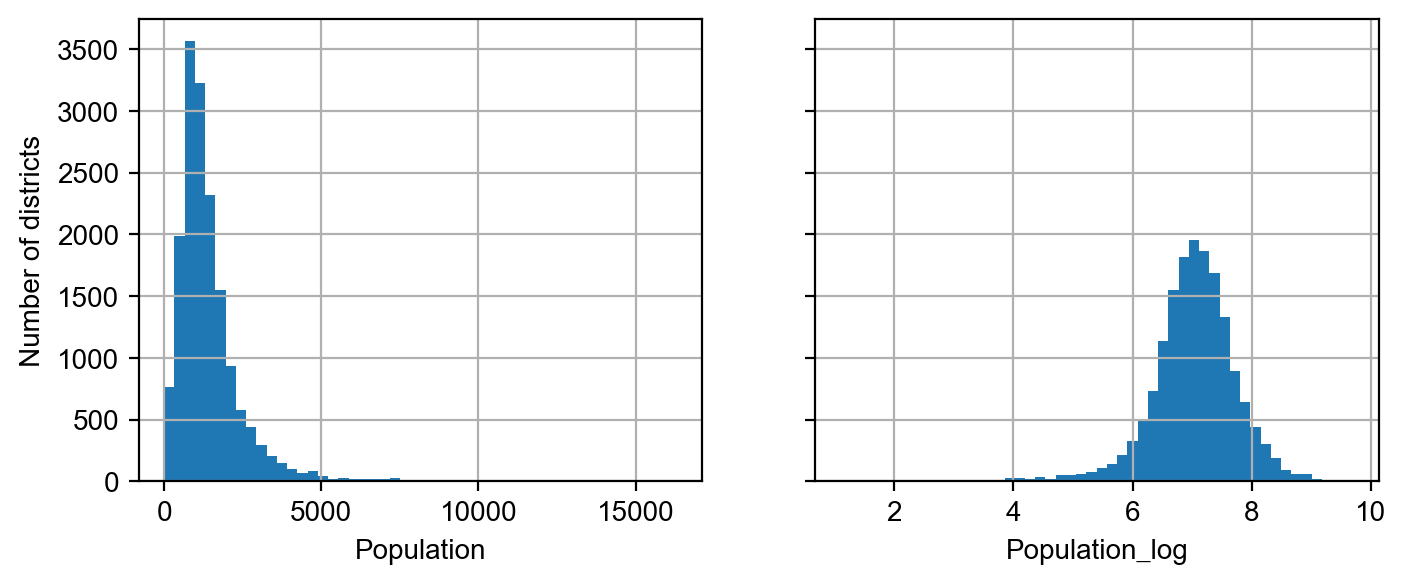

In [53]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
housing_data["population"].hist(ax=axs[0], bins=50)
housing_data["population"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Population_log")
axs[0].set_ylabel("Number of districts")
plt.show()

#### 转换为百分比

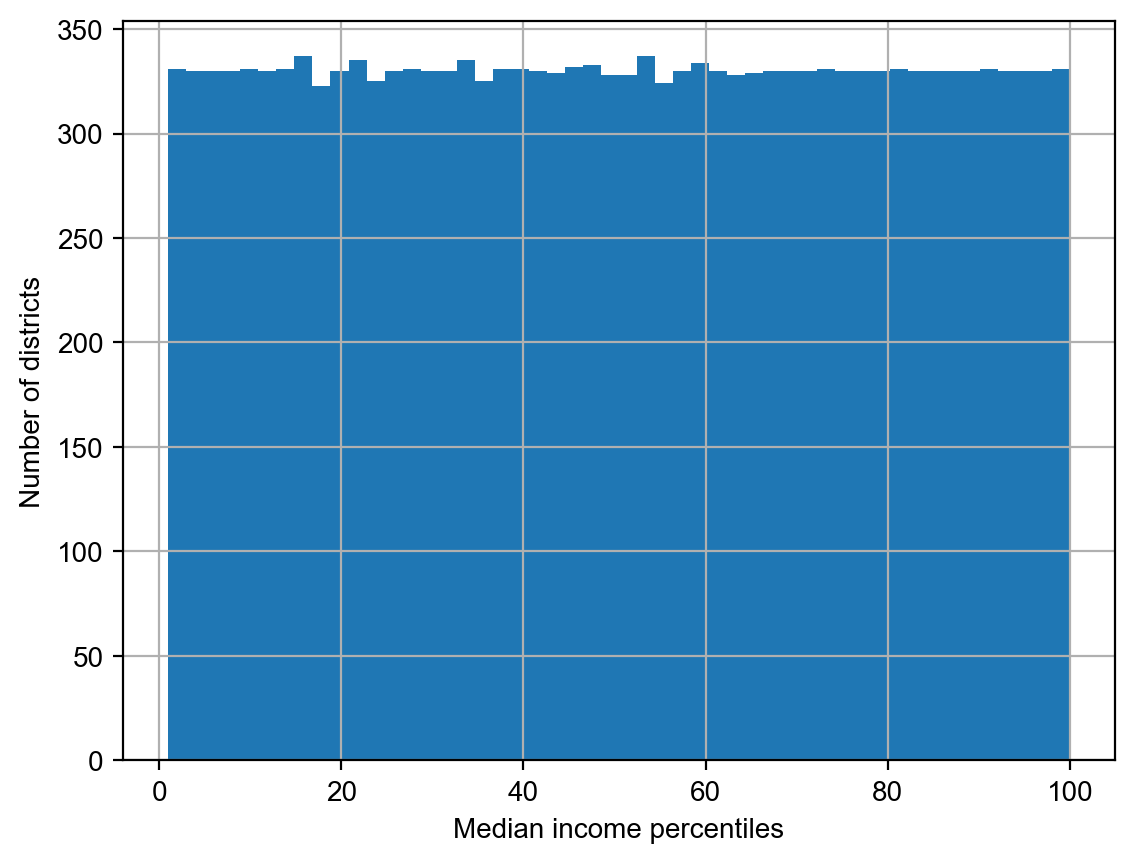

In [54]:
percentiles = [np.percentile(housing_data["median_income"], p)
               for p in range(1, 100)]
flattened_median_income = pd.cut(housing_data["median_income"], bins=[-np.inf] + percentiles + [np.inf],
                                 labels=range(1, 100 + 1))
flattened_median_income.hist(bins=50)
plt.xlabel("Median income percentiles")
plt.ylabel("Number of districts")
plt.show()

#### 另一种转换多峰分布的方法是为每个模式（至少是主要模式）添加一个特征，表示房屋年龄中位数与该特定模式之间的相似性。相似性度量通常使用径向基函数(Radial Basis Function，RBF)计算——` 任何一个仅取决于输入值和固定点之间距离的函数 `。最常用的RBF是高斯RBF，其输出值随着输入值远离固定点而呈指数衰减

In [55]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(
    housing_data[['housing_median_age']], [[35]], gamma=0.1)
len(age_simil_35)

16512

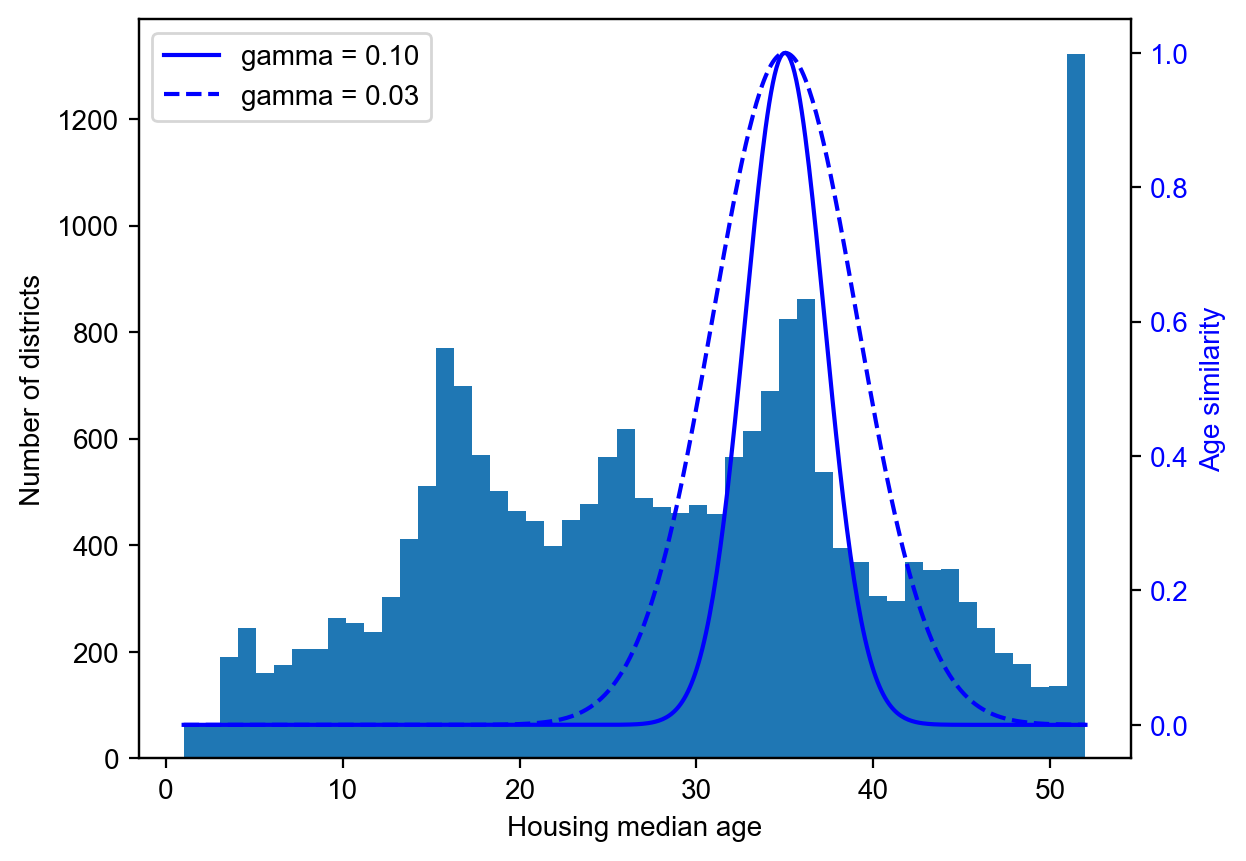

In [56]:
ages = np.linspace(housing_data["housing_median_age"].min(),
                   housing_data["housing_median_age"].max(),
                   500).reshape(-1, 1)
gamma1 = 0.1
gamma2 = 0.03
rbf1 = rbf_kernel(ages, [[35]], gamma=gamma1)
rbf2 = rbf_kernel(ages, [[35]], gamma=gamma2)

fig, ax1 = plt.subplots()

ax1.set_xlabel("Housing median age")
ax1.set_ylabel("Number of districts")
ax1.hist(housing["housing_median_age"], bins=50)

ax2 = ax1.twinx()  # create a twin axis that shares the same x-axis
color = "blue"
ax2.plot(ages, rbf1, color=color, label="gamma = 0.10")
ax2.plot(ages, rbf2, color=color, label="gamma = 0.03", linestyle="--")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel("Age similarity", color=color)

plt.legend(loc="upper left")
plt.show()

#### 对标签数据做线性回归训练

In [57]:
from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()

# 标签从Pandas Series转换为DataFrame，因为StandardScaler需要2D输入
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())
scaled_labels[:5]

array([[ 2.18511202],
       [ 2.40625396],
       [-0.90740625],
       [-0.95597075],
       [ 1.34824154]])

In [58]:
model = LinearRegression()
# 在单个原始输入特征（收入中位数）上训练模型
model.fit(housing_data[["median_income"]], scaled_labels)

LinearRegression()

In [59]:
# 选出部分待预测标签
some_new_data = housing_data[["median_income"]].iloc[:5]
scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)
predictions

array([[131997.15275877],
       [299359.35844434],
       [146023.37185694],
       [138840.33653057],
       [192016.61557639]])

#### 更简单的选择是使用TransformedTargetRegressor。我们只需要构造它，给它回归模型和标签转换器，然后使用原始的未缩放标签，将它拟合到训练集上。

In [60]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(
    regressor=LinearRegression(), transformer=StandardScaler())
model.fit(housing_data[["median_income"]], housing_labels)

# 当进行预测时，会自动调用回归模型的predict方法并使用缩放器的inverse_transform()来进行预测
predictions = model.predict(some_new_data)
predictions

array([131997.15275877, 299359.35844434, 146023.37185694, 138840.33653057,
       192016.61557639])

#### 2.5.4 定制转换器（FunctionTransformer）
#### 存在重尾分布，使用对数转换人口

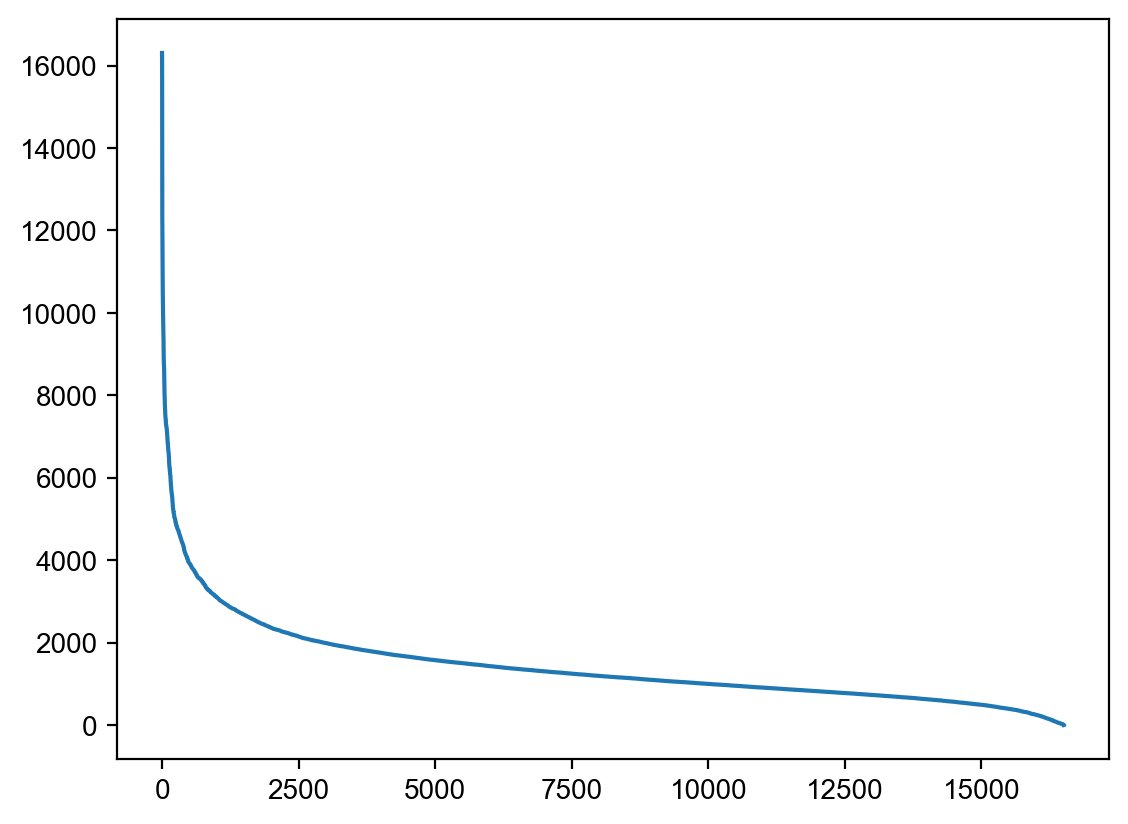

In [61]:
test = housing_data[["population"]].sort_values(
    by="population", ascending=False)
plt.plot(test.to_numpy())

In [62]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
# 对人口数据进行对数转换，消除重尾分布
log_population = log_transformer.transform(housing_data["population"])

In [63]:
log_population.head()

13096    7.362645
14973    6.501290
3785     6.331502
14689    7.520235
20507    7.555905
Name: population, dtype: float64

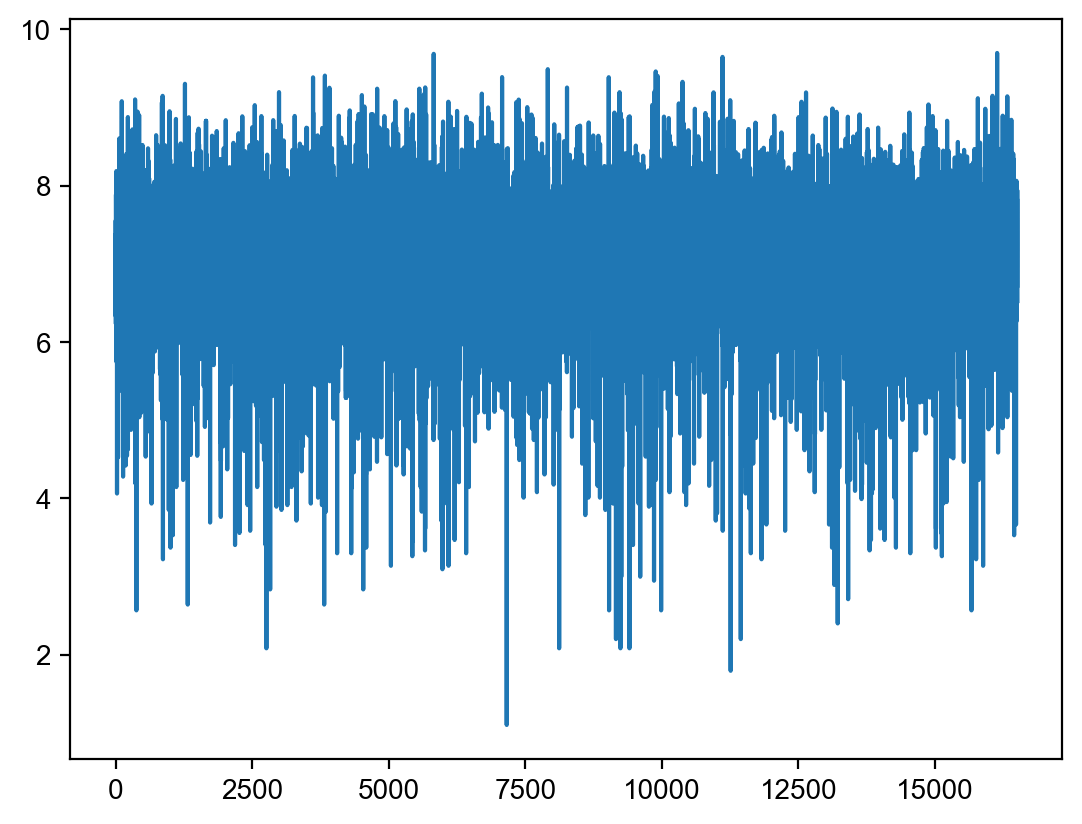

In [64]:
plt.plot(log_population.to_numpy())

In [65]:
rbf_transformer = FunctionTransformer(
    rbf_kernel, kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing_data[["housing_median_age"]])
age_simil_35[:5]

array([[2.81118530e-13],
       [8.20849986e-02],
       [6.70320046e-01],
       [8.48904403e-15],
       [9.04837418e-01]])

#### 添加一个特征来测量其他地区与旧金山之间的地理相似性

In [66]:
# 如果传入一个具有两个特征的数组，它会测量2D距离（欧几里得）来测试相似性
sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(
    rbf_kernel, kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.transform(housing_data[["latitude", "longitude"]])
sf_simil[:5]

array([[0.999927  ],
       [0.05258419],
       [0.94864161],
       [0.01192662],
       [0.03275557]])

#### 自定义转换器也可用于组合特征

In [67]:
ratio_transformer = FunctionTransformer(lambda x: x[:, [0]] / x[:, [1]])
ratio_transformer.transform(np.array([[1, 2], [3, 4]]))

array([[0.5 ],
       [0.75]])

In [68]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted


# 继承TransformerMixin会自动获得fit_transform()方法
# 继承BaseEstimator会自动获得set_params()和get_params()方法
class StandardScalerClone(BaseEstimator, TransformerMixin):

    def __init__(self, with_mean=True):
        self.scale_ = None
        self.n_features_in_ = None
        self.mean_ = None
        self.with_mean = with_mean

    def fit(self, X, y=None):
        X = check_array(X)
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]
        return self  # 必须返回self

    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_

#### 自定义转换器可以（并且经常）在其实现中使用其他估计器。例如，以下代码演示了使用KMeans的自定义转换器在fit()方法中识别出训练数据中的主要集群，然后在transform()方法中使用rbf_kernel()来测量每个样本与每个集群中心的相似程度：


In [69]:
from sklearn.cluster import KMeans


class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.kmeans_ = None
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    # 使用kmeans训练，识别出集群
    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self

    # 计算每个样本点与每个集群中心点之间的相似程度
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [70]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing_data[["latitude", "longitude"]],
                                           sample_weight=housing_labels)

In [71]:
similarities[:3].round(2)

array([[0.  , 0.98, 0.  , 0.  , 0.  , 0.  , 0.13, 0.55, 0.  , 0.56],
       [0.64, 0.  , 0.11, 0.04, 0.  , 0.  , 0.  , 0.  , 0.99, 0.  ],
       [0.  , 0.65, 0.  , 0.  , 0.01, 0.  , 0.49, 0.59, 0.  , 0.28]])

In [72]:
cluster_simil.kmeans_.cluster_centers_

array([[  33.85060232, -117.78356573],
       [  37.78134861, -122.27837164],
       [  34.69948885, -119.75445997],
       [  32.94170114, -117.03285512],
       [  40.43172026, -122.55848854],
       [  36.70545668, -119.64670039],
       [  38.44920556, -121.13887954],
       [  38.51687956, -122.69442517],
       [  34.06008475, -118.33288417],
       [  37.22873003, -121.91686502]])

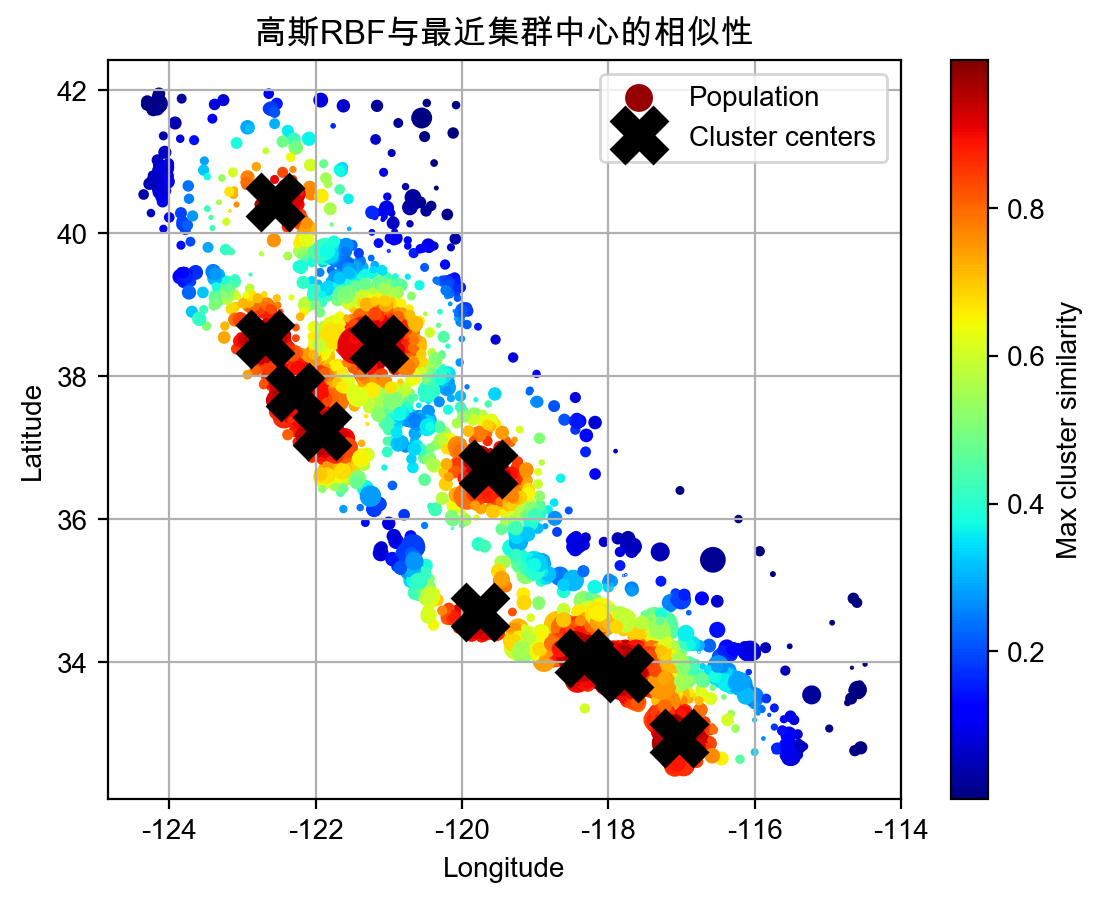

In [73]:
housing_renamed = housing_data.rename(columns={"latitude": "Latitude",
                                               "longitude": "Longitude",
                                               "population": "Population",
                                               "median_house_value": "Median_house_value(usd)"
                                               })
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)
housing_renamed.plot(kind="scatter",
                     x="Longitude",
                     y="Latitude",
                     grid=True,
                     s=housing_renamed["Population"] / 100,
                     label="Population",
                     c="Max cluster similarity",
                     cmap="jet",
                     colorbar=True,
                     legend=True,
                     sharex=False,
                     title="高斯RBF与最近集群中心的相似性")
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="",
         color="black",
         marker="X",
         markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")
plt.show()

### 转换流水线

In [74]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardise", StandardScaler()),
])

In [75]:
from sklearn import set_config

set_config(display="diagram")
num_pipeline

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('standardise', StandardScaler())])

In [76]:
# 不想给转换器命名，可以使用make_pipline创建一个流水线，只需要指定每一步使用的估计器
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                             StandardScaler())

In [77]:
# 使用流水线应用到目标数据
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

In [78]:
# 想恢复一个好的DataFrame，则你可以使用流水线的get_feature_names_out()方法
df_housing_num_prepared = pd.DataFrame(housing_num_prepared,
                                       columns=num_pipeline.get_feature_names_out(),
                                       index=housing_num.index)
df_housing_num_prepared.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
13096  -1.423037  1.013606            1.861119     0.311912        1.368167   
14973   0.596394 -0.702103            0.907630    -0.308620       -0.435925   
3785   -1.203098  1.276119            0.351428    -0.712240       -0.760709   
14689   1.231216 -0.884924           -0.919891     0.702262        0.742306   
20507   0.711362 -0.875549            0.589800     0.790125        1.595753   

       population  households  median_income  
13096    0.137460    1.394812      -0.936491  
14973   -0.693771   -0.373485       1.171942  
3785    -0.788768   -0.775727      -0.759789  
14689    0.383175    0.731375      -0.850281  
20507    0.444376    1.755263      -0.180365

In [79]:
housing_data.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
13096    -122.42     37.80                52.0       3321.0          1115.0   
14973    -118.38     34.14                40.0       1965.0           354.0   
3785     -121.98     38.36                33.0       1083.0           217.0   
14689    -117.11     33.75                17.0       4174.0           851.0   
20507    -118.15     33.77                36.0       4366.0          1211.0   

       population  households  median_income ocean_proximity  
13096      1576.0      1034.0         2.0987        NEAR BAY  
14973       666.0       357.0         6.0876       <1H OCEAN  
3785        562.0       203.0         2.4330          INLAND  
14689      1845.0       780.0         2.2618          INLAND  
20507      1912.0      1172.0         3.5292      NEAR OCEAN

In [80]:
# 返回流水线第1个估计器
num_pipeline[1]

StandardScaler()

In [81]:
# 返回除最后一个估计器之外的所有估计器
num_pipeline[:-1]

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median'))])

In [83]:
from sklearn.compose import ColumnTransformer

num_attrs = ["longitude", "latitude", "housing_median_age", "total_rooms",
             "total_bedrooms", "population", "households", "median_income"]
cat_attrs = ["ocean_proximity"]

cat_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"),
                             OneHotEncoder(handle_unknown="ignore"))
preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attrs),
    ("cat", cat_pipeline, cat_attrs)
])
preprocessing

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['ocean_proximity'])])

In [84]:
# 将流水线应用到数据中去
housing_data_prepared = preprocessing.fit_transform(housing_data)
housing_data_prepared[:2]

array([[-1.42303652,  1.0136059 ,  1.86111875,  0.31191221,  1.36816703,
         0.13746004,  1.39481249, -0.93649149,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ],
       [ 0.59639445, -0.702103  ,  0.90762971, -0.30861991, -0.43592476,
        -0.69377062, -0.37348471,  1.17194198,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ]])

In [85]:
# 转换为标准的dataframe
df_housing_data_prepared = pd.DataFrame(housing_data_prepared,
                                        columns=preprocessing.get_feature_names_out(),
                                        index=housing_data.index)
df_housing_num_prepared.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
13096  -1.423037  1.013606            1.861119     0.311912        1.368167   
14973   0.596394 -0.702103            0.907630    -0.308620       -0.435925   
3785   -1.203098  1.276119            0.351428    -0.712240       -0.760709   
14689   1.231216 -0.884924           -0.919891     0.702262        0.742306   
20507   0.711362 -0.875549            0.589800     0.790125        1.595753   

       population  households  median_income  
13096    0.137460    1.394812      -0.936491  
14973   -0.693771   -0.373485       1.171942  
3785    -0.788768   -0.775727      -0.759789  
14689    0.383175    0.731375      -0.850281  
20507    0.444376    1.755263      -0.180365

In [86]:
# 自动选择转换器名称,创建与之前相同的ColumnTransformer，只是转换器被自动命名为"pipeline-1"和"pipeline-2"，而不是"num"和"cat"
from sklearn.compose import make_column_transformer, make_column_selector

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)
preprocessing

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x32203e140>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x32203dba0>)])

In [87]:
housing_prepared = preprocessing.fit_transform(housing_data)
housing_prepared[:2]

array([[-1.42303652,  1.0136059 ,  1.86111875,  0.31191221,  1.36816703,
         0.13746004,  1.39481249, -0.93649149,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ],
       [ 0.59639445, -0.702103  ,  0.90762971, -0.30861991, -0.43592476,
        -0.69377062, -0.37348471,  1.17194198,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ]])

In [89]:
housing_prepared_fr = pd.DataFrame(
    housing_prepared,
    columns=preprocessing.get_feature_names_out(),
    index=housing_data.index)
housing_prepared_fr.head(2)

pipeline-1__longitude  pipeline-1__latitude  \
13096              -1.423037              1.013606   
14973               0.596394             -0.702103   

       pipeline-1__housing_median_age  pipeline-1__total_rooms  \
13096                        1.861119                 0.311912   
14973                        0.907630                -0.308620   

       pipeline-1__total_bedrooms  pipeline-1__population  \
13096                    1.368167                0.137460   
14973                   -0.435925               -0.693771   

       pipeline-1__households  pipeline-1__median_income  \
13096                1.394812                  -0.936491   
14973               -0.373485                   1.171942   

       pipeline-2__ocean_proximity_<1H OCEAN  \
13096                                    0.0   
14973                                    1.0   

       pipeline-2__ocean_proximity_INLAND  pipeline-2__ocean_proximity_ISLAND  \
13096                                 0.0                                 0.0   
14973                                 0.0                                 0.0   

       pipeline-2__ocean_proximity_NEAR BAY  \
13096                                   1.0   
14973                                   0.0   

       pipeline-2__ocean_proximity_NEAR OCEAN  
13096                                     0.0  
14973                                     0.0

#### 创建一个流水线，执行前面的所有操作

In [89]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]


def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out


def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())


log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())
preprocessing = ColumnTransformer([
    ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
    ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
    ("people_per_house", ratio_pipeline(), ["population", "households"]),
    ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                           "households", "median_income"]),
    ("geo", cluster_simil, ["latitude", "longitude"]),
    ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
],
    remainder=default_num_pipeline)  # one column remaining: housing_median_age
preprocessing

ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                             SimpleImputer(strategy='median')),
                                            ('standardscaler',
                                             StandardScaler())]),
                  transformers=[('bedrooms',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('functiontransformer',
                                                  FunctionTransformer(feature_names_out=<function ratio_name at 0x17fe2ad40>,
                                                                      func=<function column_ratio at 0...
                                 ['total_bedrooms', 'total_rooms', 'population',
                                  'households', 'median_income']),
                                ('geo', ClusterSimilarity(random_state=42),
                                 ['latitude', 'longitude']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x116e77220>)])

In [90]:
housing_prepared = preprocessing.fit_transform(housing_data)
housing_prepared.shape

(16512, 24)

In [91]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)